# Implementation of GraphSAGE:

Graph Neural Network: Nowadays, we are overwhelmed by different kinds of data, traditionally like table-like data, and unstructured data like text but when it comes graph data, how to better capture the topology information for Machine Learning is a new challenge because unlike structure data, there’re different shapes of topology that represent different topology structures. GraphSAGE is a Graph Neural Network Deep Leering model is not only able to capture the nodes’ attributes but also to represent and capture topology information for each node in a graph, for supervised machine learning.
According to the paper: https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf proposed by Stanford University, I implement the GraphSage and share details in codes at this Juypter notebook below:


![](./graphsage.png)

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import time
from tensorflow.keras.layers import TimeDistributed

###### prameter

In [2]:
num_nodes = 300 #### number of  nodes for dataset
feature_size = 32 # size of features for eacho nodes
conn_ratio = 0.1 ### connection ratio for eacho nodes for graph
bidirected = False #### is your graph is bidirected ?
overlap_nodes = 10 ### overlap nodes for communities
sample_nodes_size = 15 ### how many nodes will be sampled
sample_time =  5 ### how many time each node will be sampled
batch_size = 32 ### batch size for training
d_model = 128 ## number of dimension for graphSage model
EPOCHS = 10 ###

### 1) Create random dataset

In [3]:
def create_adjacency_matrix(num_nodes,conn_ratio = 0.05,bidirected = True):
    matrix = []
    
    for node in range(num_nodes):
        num_list= [np.random.randint(0,int(1/conn_ratio)) for _ in range(num_nodes)]
        ### make sure have at least one connection and not self-connected
       
        num_list[node]=1
        
        if 0 not in num_list: 
            random_index = node
            while random_index==node:
                random_index = np.random.randint(0,num_nodes)
            num_list[random_index]=0
            
        zero_one_list=[]
        zero_one_list = [1 if num==0 else 0 for num in num_list]
        matrix.append(zero_one_list)
    
    matrix = np.array(matrix)
    
    
    if bidirected:
        for (index,row) in enumerate(matrix):
            matrix[:,index]=row
    
    return matrix

In [4]:
adjacency_matrix = create_adjacency_matrix(num_nodes = num_nodes,conn_ratio = conn_ratio,bidirected = bidirected)

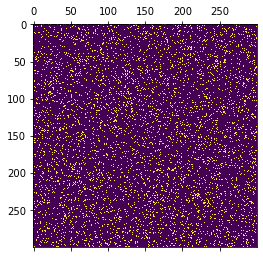

In [5]:
plt.matshow(adjacency_matrix)

In [6]:
#### create three communities graph
for row in range(100+overlap_nodes,num_nodes):
    for column in range(0,100):
        adjacency_matrix[row,column]=0
        adjacency_matrix[column,row]=0

In [7]:
for row in range(200+overlap_nodes,num_nodes):
    for column in range(0,200):
        adjacency_matrix[row,column]=0
        adjacency_matrix[column,row]=0

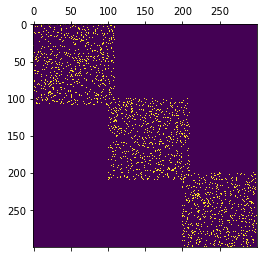

In [8]:
plt.matshow(adjacency_matrix)

In [9]:
feature_matrix = np.random.randn(num_nodes,feature_size)

In [10]:
#### padding for the same shape
paddding = np.zeros((1,feature_size))

In [11]:
feature_padding_matrix = np.concatenate((paddding,feature_matrix),axis = 0)

In [12]:
def create_random_label(num_nodes,positve_ratio = 0.1):
    num_list= [np.random.randint(0,int(1/positve_ratio)) for _ in range(num_nodes)]
    labels = [1 if num==0 else 0 for num in num_list]
    return labels

In [13]:
labels = create_random_label(num_nodes,0.1)

In [14]:
def onehot_reverse_func(onehot):
    return [index + 1  for (index,value) in enumerate(onehot) if value==1]

In [15]:
connected_bynodes_dict  = {index+1:onehot_reverse_func(row) for (index,row) in enumerate(adjacency_matrix)}

In [16]:
connected_bynodes_dict[0] = [0 for _ in range(sample_nodes_size) ]

In [17]:
max_len = max([len(conn_list) for conn_list in connected_bynodes_dict.values() ])

In [18]:
max_len

26

In [19]:
min_len = min([len(conn_list) for conn_list in connected_bynodes_dict.values() ])

In [20]:
min_len

4

In [21]:
node_conn_list = [value for (key,value) in connected_bynodes_dict.items()]

In [22]:
node_index_list = [key for (key,value) in connected_bynodes_dict.items()]

### 2) Visualize the network

In [23]:
def draw_graph(adjacency_matrix,labels,isDirected = True,figsize=(15,7)):
    if isDirected:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    
    edge_list = []    
    for (node_1,row) in enumerate(adjacency_matrix):
        for (node_2,value) in enumerate(row):
            if value==1:
                edge_list.append((node_2+1,node_1+1)) ####  Attention: isconnected flag  
    G.add_edges_from(edge_list)
    plt.figure(figsize=figsize)
    labels = [ 'orange' if label==1 else 'grey' for label in labels] 
    nx.draw(G,with_labels = True,node_color=labels)
    

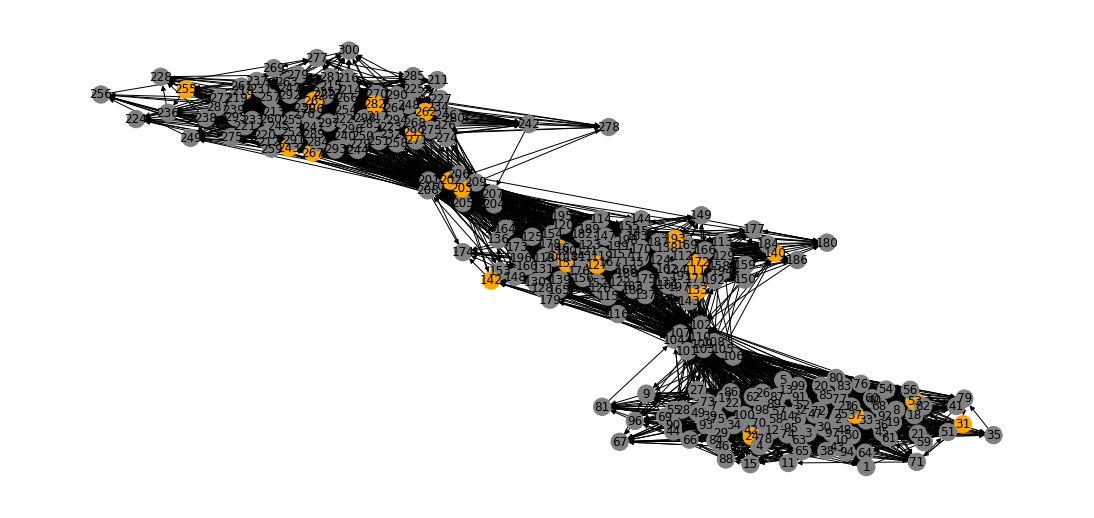

In [24]:
draw_graph(adjacency_matrix,labels)

### 3) Backward look up training data preparation

In [25]:
def list_padding(sequence,maxlen):
    current_len = len(sequence)
    lack_len = maxlen-current_len
    sequence = sequence + [0 for _ in range(lack_len)] 
    return sequence 

In [26]:
def backward_lookup_data_genreate(connected_bynodes_dict,sample_nodes_size,sample_time):
    batch_input_data = []
    batch_label_data = []
    
    node_conn_list = [value for (key,value) in connected_bynodes_dict.items()]
    
    for _ in range(sample_time):
        all_gather_node_list = []
        for conn_list in node_conn_list[:-1]:
            gather_node_list = []
            try:### 
                conn_list = random.sample(conn_list,sample_nodes_size) 
            except ValueError:
                conn_list  = list_padding(conn_list,sample_nodes_size)
            for node in conn_list:
                try:
                    gather_node_list.append(random.sample(connected_bynodes_dict[node],sample_nodes_size))
                except ValueError:
                    gather_node_list.append(connected_bynodes_dict[node])
            all_gather_node_list.append(pad_sequences(gather_node_list,padding='post',maxlen = sample_nodes_size))

        batch_input_data.extend(all_gather_node_list)
        batch_label_data.extend(labels)
    return np.array(batch_input_data),np.array(batch_label_data)

In [27]:
sample_nodes_size

15

In [28]:
sample_time

5

In [29]:
padding_input_data,padding_label_data = backward_lookup_data_genreate(connected_bynodes_dict,sample_nodes_size,sample_time)

In [30]:
padding_input_data.shape

(1500, 15, 15)

In [31]:
np.array(padding_input_data).shape

(1500, 15, 15)

In [32]:
padding_input_data[0]

array([[  1,   4,  10,  12,  20,  31,  42,  43,  44,  56,  78,  92, 105,
          0,   0],
       [ 33,  35,  44,  59,  73,  81,  84, 100,   0,   0,   0,   0,   0,
          0,   0],
       [  2,  12,  39,  44,  49,  53,  68,  76,  77,  80,  98, 106, 108,
          0,   0],
       [  4,   7,  11,  13,  48,  84,  90,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 13,  21,  28,  31,  34,  40,  43,  71,  77,  99,   0,   0,   0,
          0,   0],
       [  6,  29,  39,  64,  70, 102, 104,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 33,  19,  61,  51,  94,  95,  13,  77,   7,  44,  24,  89,   2,
        101,  38],
       [  4,  15,  39,  46,  48,  63,  68,  69,  86,  89,  96, 102,   0,
          0,   0],
       [ 12,  39,  52,  54,  57,  70,  78,  89,   0,   0,   0,   0,   0,
          0,   0],
       [  3,  15,  19,  20,  30,  36,  45,  59,  81,  90,  98, 103, 109,
          0,   0],
       [ 10,  12,  32,  42,  51,  53,  66,  86,  94,  95,  97,  99, 108,
       

### 3) Model Constructure

In [33]:
class FeaturesEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self,feature_padding_matrix):
        super(FeaturesEmbeddingLayer, self).__init__()
        self.feature_padding_matrix = feature_padding_matrix
        self.embedding_lookup = tf.nn.embedding_lookup
    def call(self,batch_input):
        batch_embedding_output = self.embedding_lookup(self.feature_padding_matrix,batch_input)
        return batch_embedding_output

In [34]:
features_embedding_layer = FeaturesEmbeddingLayer(feature_padding_matrix)

In [35]:
example_padding_input = padding_input_data[:64]

In [36]:
example_padding_input.shape

(64, 15, 15)

In [37]:
batch_embedding_output = features_embedding_layer(example_padding_input)

In [38]:
batch_embedding_output.shape

TensorShape([64, 15, 15, 32])

In [39]:
class LSTMAggLayer1(tf.keras.layers.Layer):
    def __init__(self,num_units):
        super(LSTMAggLayer1,self).__init__()
        self.num_units = num_units
        self.Bidirectional = TimeDistributed(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_units)))
    def call(self,x):
        output = self.Bidirectional(x)
        return output

In [40]:
class LSTMAggLayer2(tf.keras.layers.Layer):
    def __init__(self,num_units):
        super(LSTMAggLayer2,self).__init__()
        self.num_units = num_units
        self.Bidirectional = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_units))
    def call(self,x):
        output = self.Bidirectional(x)
        return output

In [41]:
lstm_layer_1 = LSTMAggLayer1(128)

In [42]:
batch_embedding_output.shape

TensorShape([64, 15, 15, 32])

In [43]:
lstm_layer_1_output = lstm_layer_1(batch_embedding_output)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [44]:
lstm_layer_2 = LSTMAggLayer2(128)

In [45]:
lstm_layer_1_output.shape

TensorShape([64, 15, 256])

In [46]:
lstm_layer_2_output = lstm_layer_2(lstm_layer_1_output)

In [47]:
lstm_layer_2_output.shape

TensorShape([64, 256])

In [48]:
class FinalAggLayer(tf.keras.layers.Layer):
    def __init__(self,num_units):
        super(FinalAggLayer,self).__init__()
        self.agg_layer1 = LSTMAggLayer1(num_units)
        self.agg_layer2 = LSTMAggLayer2(num_units)

    def call(self,batch_embedding_output):
        layer_output = self.agg_layer1(batch_embedding_output)
        layer_output = self.agg_layer2(layer_output)

        return layer_output

In [49]:
aggregation_layer = FinalAggLayer(20)

In [50]:
class GraphSAGE_LSTM(tf.keras.Model):
    def __init__(self,num_units,feature_padding_matrix):
        super(GraphSAGE_LSTM, self).__init__()
        self.embedding_layer = FeaturesEmbeddingLayer(feature_padding_matrix)
        self.final_agg_layer = FinalAggLayer(num_units)
        self.w = tf.keras.layers.Dense(num_units, activation='relu')
        self.final_layer = tf.keras.layers.Dense(1,activation='sigmoid')
    
    def call(self, inp):
        embedding_output = self.embedding_layer(inp)
        agg_output = self.final_agg_layer(embedding_output)
        final_output = self.w(agg_output)
        final_output = self.final_layer(final_output)
        
        return final_output

In [51]:
feature_padding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26882384, -0.29441597,  0.11144894, ..., -0.12217319,
        -0.51567843, -1.20216502],
       [-1.00064874,  0.77308573, -0.54695712, ..., -1.32223272,
        -0.27016533,  0.12775888],
       ...,
       [ 1.52508862,  1.05264101, -0.43063973, ...,  0.70429193,
        -0.69512903, -1.19881888],
       [ 0.66751523, -0.1979257 ,  1.75982215, ...,  1.33003502,
         0.69332383, -0.91863831],
       [ 0.32458794,  0.26995297, -0.30829743, ...,  1.1939877 ,
        -0.93021775, -0.85656166]])

In [52]:
model = GraphSAGE_LSTM(d_model,feature_padding_matrix)

In [53]:
padding_input_data[:16].shape

(16, 15, 15)

In [54]:
batch_example = padding_input_data[:16]

In [55]:
# model(batch_example)

In [56]:
# model.summary()

In [57]:
padding_label_data[:16]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [58]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### 4) Dataset prepare

In [59]:
train_split = 0.7

In [60]:
train_index = int(len(padding_input_data) * train_split)

In [61]:
train_input_data =padding_input_data[:train_index]
train_label_data =padding_label_data[:train_index]

In [62]:
dev_input_data =padding_input_data[train_index:]
dev_label_data =padding_label_data[train_index:]

In [63]:
def batch_generate(x,y,batch_size):
    
    sample_size = len(y)
    
    loop_cnt = sample_size//batch_size
    
    inp_list  = []
    tar_list = []
    
    for start_index in range(loop_cnt):
        start_index = start_index*batch_size
        end_index = start_index+batch_size
        x_batch = x[start_index:end_index]
        y_batch = y[start_index:end_index]
        inp_list.append(x_batch)
        tar_list.append(y_batch)
        
        
    if end_index!=(sample_size -1):
        x_batch = x[end_index:]
        y_batch = y[end_index:]
        
        inp_list.append(x_batch)
        
        tar_list.append(y_batch)
    
    return np.array(inp_list),np.array(tar_list)

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_label_data))

train_dataset = train_dataset.shuffle(5000).batch(batch_size)

dev_dataset = tf.data.Dataset.from_tensor_slices((dev_input_data, dev_label_data))

dev_dataset = dev_dataset.shuffle(5000).batch(batch_size)

In [65]:
### simple 
history = model.fit(train_dataset, epochs=10,
                    validation_data=dev_dataset, 
                    validation_steps=2)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

33/33 [==============================] - 10s 311ms/step - loss: 0.6352 - accuracy: 0.8410 - val_loss: 0.5265 - val_accuracy: 0.9375
Epoch 2/10
33/33 [==============================] - 7s 227ms/step - loss: 0.3424 - accuracy: 0.9267 - val_loss: 0.4186 - val_accuracy: 0.8750
Epoch 3/10
33/33 [==============================] - 8s 228ms/step - loss: 0.2675 - accuracy: 0.9267 - val_loss: 0.2790 - val_accuracy: 0.9219
Epoch 4/10
33/33 [==============================] - 7s 225ms/step - loss: 0.2517 

##### Custom Training (Optional)

In [66]:
# batch_train_input_data,batch_train_label_data = batch_generate(train_input_data,train_label_data,batch_size)

# batch_dev_input_data,batch_dev_label_data = batch_generate(dev_input_data,dev_label_data,batch_size)

In [67]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -0.8)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0, 0.5, 'Learning Rate')

Text(0.5, 0, 'Train Step')

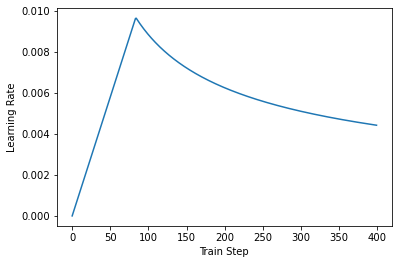

In [68]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(400, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [69]:
learning_rate = CustomSchedule(d_model)

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [71]:
loss_function = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, reduction='auto')

In [72]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(
    name='train_accuracy')

In [73]:
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(
    name='val_accuracy')

In [74]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(text_classifer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [75]:
@tf.function
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        predictions = model(inp)
        loss = loss_function(tar, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_accuracy(tar, predictions)

In [76]:
def val_step(inp_val,tar_val):
    predictions_val = model(inp_val)
    loss_val = loss_function(tar_val, predictions_val)
    
    val_loss(loss_val)
    val_accuracy(tar_val,predictions_val)
    

In [77]:
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    val_loss.reset_states()
    val_accuracy.reset_states()


    for (batch, (inp, tar)) in enumerate(train_dataset):
        
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Traing Loss {:.4f} Traing Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result(), ))


    for (val_inp,val_tar) in dev_dataset:
        val_step(val_inp,val_tar)
    

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    print ('Epoch {} Training Loss {:.4f} Training Accuracy {:.4f} Val Loss {:.4f} Val Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                val_loss.result(),
                                                val_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Traing Loss 0.0132 Traing Accuracy 1.0000
Epoch 1 Training Loss 0.2987 Training Accuracy 0.9259 Val Loss 0.2164 Val Accuracy 0.9271
Time taken for 1 epoch: 25.890708923339844 secs

Epoch 2 Batch 0 Traing Loss 0.0694 Traing Accuracy 1.0000
Epoch 2 Training Loss 0.1467 Training Accuracy 0.9449 Val Loss 0.2194 Val Accuracy 0.9375
Time taken for 1 epoch: 10.111738443374634 secs

Epoch 3 Batch 0 Traing Loss 0.0780 Traing Accuracy 0.9688
Epoch 3 Training Loss 0.0873 Training Accuracy 0.9647 Val Loss 0.1247 Val Accuracy 0.9646
Time taken for 1 epoch: 13.925137519836426 secs

Epoch 4 Batch 0 Traing Loss 0.0372 Traing Accuracy 1.0000
Epoch 4 Training Loss 0.0249 Training Accuracy 0.9915 Val Loss 0.2233 Val Accuracy 0.9375
Time taken for 1 epoch: 12.920965671539307 secs

Epoch 5 Batch 0 Traing Loss 0.0236 Traing Accuracy 0.9688
Saving checkpoint for epoch 5 at ./checkpoints/train\ckpt-3
Epoch 5 Training Loss 0.0337 Training Accuracy 0.9846 Val Loss 0.1397 Val Accuracy 0.9583
Time

In [78]:
#### custome training better

In [113]:
next(iter(train_dataset))[0]

<tf.Tensor: shape=(32, 15, 15), dtype=int32, numpy=
array([[[172, 271, 197, ..., 157, 249, 254],
        [218, 223, 229, ...,   0,   0,   0],
        [205, 214, 222, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ 10, 181, 183, ..., 164, 147,  49],
        [206, 106, 105, ..., 196, 115, 143],
        [139, 145, 147, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  5,  28,  35, ..., 108,   0,   0],
        [  8,  29,  32, ...,   0,   0,   0],
        [  2,  11,  16, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[107, 108, 118, ..., 187,   0,   0],
        [114, 115, 119, ...,   0,  

In [81]:
sample = next(iter(dev_dataset))[0]

In [82]:
model.predict(sample)

array([[2.0196621e-06],
       [2.7732253e-03],
       [9.9964690e-01],
       [5.7306139e-08],
       [9.4918951e-12],
       [9.9916583e-01],
       [2.6118394e-05],
       [1.3229251e-04],
       [8.4577322e-02],
       [4.9840775e-01],
       [6.4843893e-04],
       [3.6123765e-07],
       [2.6360848e-07],
       [1.3555615e-05],
       [6.0989361e-05],
       [6.7040324e-04],
       [9.6393444e-09],
       [1.9981810e-05],
       [2.3758950e-10],
       [5.0280988e-07],
       [8.0705203e-09],
       [2.1381162e-07],
       [3.5009766e-08],
       [1.7739676e-07],
       [2.0401270e-05],
       [2.7108780e-11],
       [6.2788004e-08],
       [2.2235513e-04],
       [1.2955913e-06],
       [4.2905258e-06],
       [2.4409877e-11],
       [2.8135042e-07]], dtype=float32)